In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

In [2]:
import copy
import numpy as np

from SDM.simulation.runner import Runner
from SDM.simulation.state import State
from SDM.simulation.colliders import SDM
from SDM.simulation.discretisations import constant_multiplicity
from SDM.simulation.spectra import Exponential
from SDM.simulation.kernels import Golovin
from SDM.backends.default import Default
from SDM.utils.physics import Physics
from SDM.utils.plotter import Plotter

In [3]:
class SetupA:
    x_min = Physics.r2x(10e-6)   # not given in the paper
    x_max = Physics.r2x(100e-6)  # not given in the paper

    n_sd = 2 ** 13
    n_part = 2 ** 23  # [m-3]
    X0 = 4/3 * np.pi * 30.531e-6**3
    dv = 1e6  # [m3]
    norm_factor = n_part * dv
    rho = 1000  # [kg m-3]

    dt = 1  # [s]
    
    steps = [0, 1200, 2400, 3600]

    kernel = Golovin(b=1.5e3)  # [s-1]
    spectrum = Exponential(norm_factor=norm_factor, scale=X0)
    
    backend = Default

    # TODO: rename?
    def check(self, state, step):
        check_LWC = 1e-3  # kg m-3
        check_ksi = self.n_part * self.dv / self.n_sd

        # multiplicities
        if step == 0:
            np.testing.assert_approx_equal(np.amin(state['n']), np.amax(state['n']), 1)
            np.testing.assert_approx_equal(state['n'][0], check_ksi, 1)

        # liquid water content
        LWC = self.rho * np.dot(state['n'], state['x']) / self.dv
        np.testing.assert_approx_equal(LWC, check_LWC, 3)

In [4]:
def run(setup):
    x, n = constant_multiplicity(setup.n_sd, setup.spectrum, (setup.x_min, setup.x_max))
    state = State(n=n, extensive={'x': x}, intensive={}, segment_num=1, backend=setup.backend)
    collider = SDM(setup.kernel, setup.dt, setup.dv, n_sd=setup.n_sd, backend=setup.backend)
    runner = Runner(state, (collider,))

    states = {}
    for step in setup.steps:
        runner.run(step - runner.n_steps)
        setup.check(runner.state, runner.n_steps)
        states[runner.n_steps] = copy.deepcopy(runner.state)

    return states, runner.stats


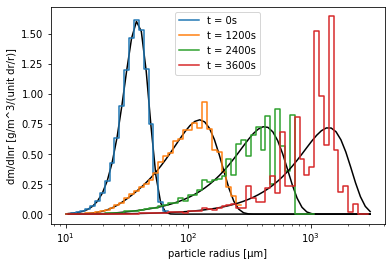

In [5]:
with np.errstate(all='raise'):
    setup = SetupA()
    states, _ = run(setup)

    x_min = min([state.min('x') for state in states.values()])
    x_max = max([state.max('x') for state in states.values()])

with np.errstate(invalid='ignore'):
    plotter = Plotter(setup, (x_min, x_max))
    for step, state in states.items():
        plotter.plot(state, step * setup.dt)
    plotter.show()
